In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil, os, random,cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

In [3]:
#Miranda images, García attributes V1 for getting image list
train_dataset_url = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV1/train_5000.csv"
test_dataset_url = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV1/test_5000.csv"

In [4]:
folder="./MonoSamples/WOW_5/"

In [5]:
images=os.listdir(folder)
random.shuffle(images)
images=images[:22000]
print(len(images))

22000


In [7]:
len(images)

22000

### Orden aleatorio del dataset

In [5]:
#%% Importing the dataset
trainDataset = pd.read_csv(train_dataset_url)
ImagesTrain=trainDataset.iloc[:, -1].values
Y_train = trainDataset.iloc[:, -2].values

testDataset = pd.read_csv(test_dataset_url)
ImagesTest = testDataset.iloc[:, -1].values
Y_test = testDataset.iloc[:, -2].values

In [27]:
folder="../../../Dataset/Mono/MirandaImages"

In [29]:
mpimg.imread(folder+str(ImagesTrain[0])[1:].replace("\\","/"))

array([[222, 223, 222, ...,  50,  54,  53],
       [222, 222, 222, ...,  51,  55,  56],
       [222, 222, 222, ...,  51,  57,  58],
       ...,
       [214, 215, 217, ...,  54,  22,  68],
       [214, 215, 217, ...,  53,  24,  71],
       [214, 215, 217, ...,  52,  25,  73]], dtype=uint8)

In [44]:
import time
t = time.time()
X_Train=np.array([ mpimg.imread(folder+str(ImagesTrain[i])[1:].replace("\\","/"))/255.0  for i in range(len(ImagesTrain))],dtype=np.float32)
X_Test=np.array([ mpimg.imread(folder+str(ImagesTest[i])[1:].replace("\\","/"))/255.0  for i in range(len(ImagesTest))],dtype=np.float32)
elapsed = time.time() - t
print(elapsed)

7.0899574756622314


### Obteniendo las categorías

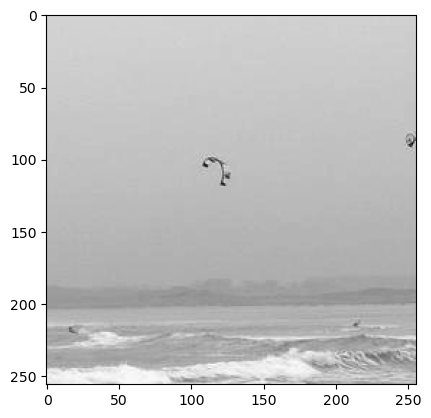

In [45]:
plt.imshow(mpimg.imread(folder+ImagesTrain[15]),cmap="gray")
plt.show()

### Obteniendo data de x

In [12]:
import time

# Acá se usan 30GB de memoria (?) algo raro está pasando, de pronto hay que convertirlo a np array en otra línea. List comprehension usa mucha memoria...

In [14]:
import gc
gc.enable()
gc.garbage

[]

In [35]:
print(X_Train.shape)

(3999, 256, 256)


#Aqeuí realizar el cálculo del tiempo con los diferentes métodos (.append, con diccionario, con list comprehension, con reshape directamente, sin reshape)

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(x)
X_scaled[:5]

features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]

values, vectors = np.linalg.eig(cov_matrix)
values[:5]

vectors[:5]

### Dividiendo entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#reshape data to fit model
X_train = X_train.reshape(71647,128,128,3)
X_test = X_test.reshape(17912,128,128,3)

# **3. Base Convolucional**

In [20]:
gc.collect()

3524

In [22]:
gc.collect()

0

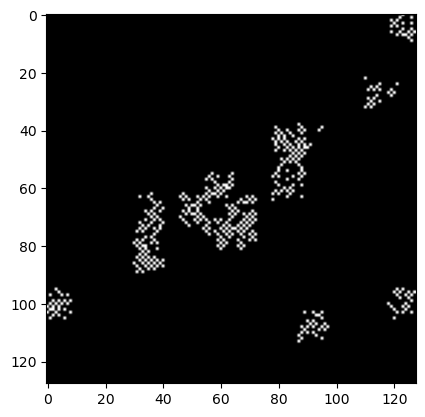

In [25]:
from scipy import ndimage
kernal=   np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')/12  
    
plt.imshow(ndimage.convolve(cover, kernal)-ndimage.convolve(stego, kernal),cmap='gray')#-ndimage.convolve(stego, kernal)
plt.show()

In [26]:
gc.collect()

6252

In [49]:
X_Train=X_Train.reshape(X_Train.shape[0],X_Train.shape[1],X_Train.shape[2],1)
X_Test=X_Test.reshape(X_Test.shape[0],X_Test.shape[1],X_Test.shape[2],1)

# Acá también se usa mucha memoria

In [50]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=20,restore_best_weights=True)
#Conv

model = models.Sequential()
model.add(layers.Conv2D(256,(5,5), padding='valid',strides=[1, 1],
                  input_shape=(256, 256,1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(BatchNormalization())
#Dense
model.add(layers.Flatten())#, activation='relu'
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='softmax'))
#Comp
customSGD=tf.optimizers.SGD(learning_rate=0.015)
customAdam=tf.optimizers.Adam(learning_rate=0.02)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy',f1_m,precision_m, recall_m])
    # Generate a print
print('------------------------------------------------------------------------')
#Fitting
history = model.fit(X_Train, Y_train,validation_data=(X_Test, Y_test), epochs=200, callbacks=[earlystopping],batch_size=64)
print("\n\n\n\n\nFitted")
#dataMqtt={"Fold":str(fold_no),"timestamp":str(datetime.now()),"Loss":str(test_loss), "Acc":str(test_acc),"F1":str(f1_score),"Precision":str( precision),"Recall": str(recal)}
#dataMqtt_out=json.dumps(data)
#retMqtt= client1.publish("stegian/data",dataMqtt_out)


------------------------------------------------------------------------
Epoch 1/200
63/63 [==============================] - 1844s 29s/step - loss: 7.6227 - accuracy: 0.5001 - f1_m: 0.6647 - precision_m: 0.5003 - recall_m: 1.0000 - val_loss: 7.6170 - val_accuracy: 0.5005 - val_f1_m: 0.6674 - val_precision_m: 0.5008 - val_recall_m: 1.0000
Epoch 2/200
63/63 [==============================] - 1830s 29s/step - loss: 7.6227 - accuracy: 0.5001 - f1_m: 0.6643 - precision_m: 0.5008 - recall_m: 1.0000 - val_loss: 7.6170 - val_accuracy: 0.5005 - val_f1_m: 0.6674 - val_precision_m: 0.5008 - val_recall_m: 1.0000
Epoch 3/200
63/63 [==============================] - 1832s 29s/step - loss: 7.6227 - accuracy: 0.5001 - f1_m: 0.6653 - precision_m: 0.5003 - recall_m: 1.0000 - val_loss: 7.6170 - val_accuracy: 0.5005 - val_f1_m: 0.6674 - val_precision_m: 0.5008 - val_recall_m: 1.0000
Epoch 4/200
63/63 [==============================] - 1819s 29s/step - loss: 7.6227 - accuracy: 0.5001 - f1_m: 0.6649 - prec

NameError: name 'gc' is not defined

32/32 - 149s - loss: 7.6170 - accuracy: 0.5005 - f1_m: 0.6686 - precision_m: 0.5022 - recall_m: 1.0000
Loss: 7.6169867515563965 
Accuracy: 0.500500500202179 
F1 score: 0.6685605049133301 
Precision: 0.5022321343421936 
Recall 1.0


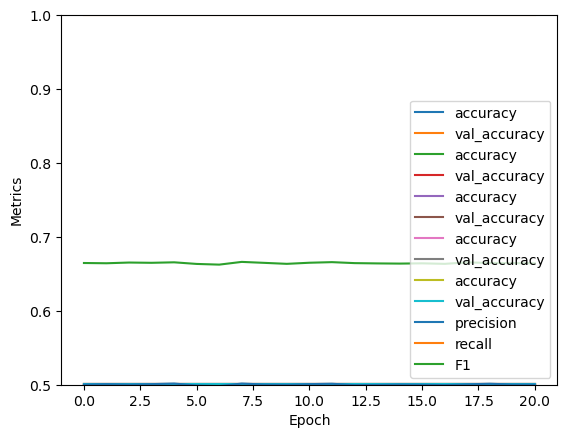

Next fold


In [55]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc,f1_score, precision, recall = model.evaluate(X_Test, Y_test, verbose=2)
print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)

plt.plot(history.history['precision_m'], label='precision')
plt.plot(history.history['recall_m'], label = 'recall')
plt.plot(history.history['f1_m'], label = 'F1')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend(loc='lower right')
plt.show()

In [56]:
# Generate generalization metrics
scores = model.evaluate(X_Test, Y_test, verbose=0)
print(f'Score for model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


Score for model: loss of 7.6169867515563965; accuracy of 50.050050020217896%


#model.build((None,128,128,3))
model.summary()

# **4. Agregar capas densas en la parte superior**

In [ ]:
model.summary()

# **5. Compilar y entrenar el modelo**



In [ ]:
model.save("CNNv2_Mono_WOW5.h5")

# **6. Evaluar el modelo**